In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)

columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day']
df_training.drop(columns2remove, inplace=True, axis=1)

attributes = [col for col in df_training.columns if col != class_name]

#Primo tipo di normalizzazione: Z-Score 
scaler = StandardScaler()
X_train = scaler.fit_transform(df_training[attributes].values)
y_train = df_training[class_name]

X_test = scaler.fit_transform(df_test[attributes].values)
y_test = df_test[class_name]

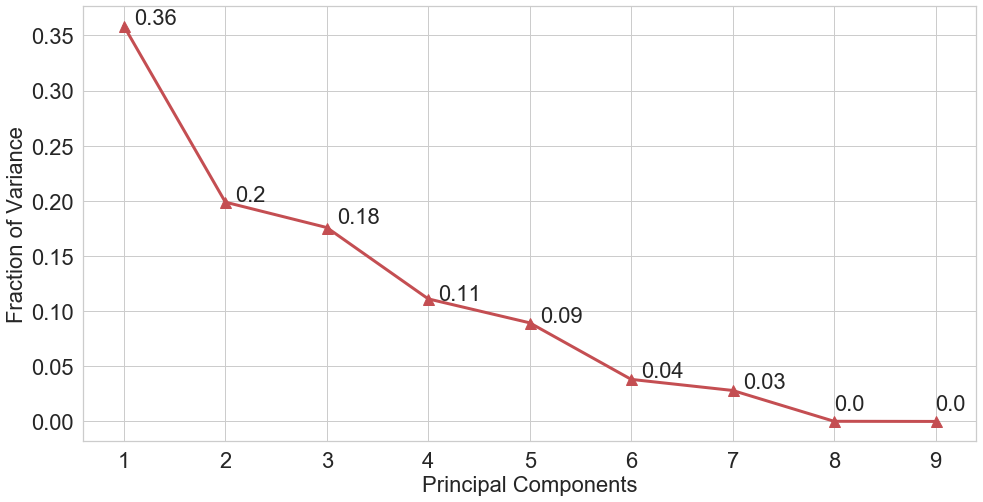

In [6]:
plt.figure(figsize=(16,8))
pca9 = PCA(n_components=len(attributes)).fit(X_train) # pca con tutti gli attributi per vedere quanta variabilità cattura ogni singola feature
var = pca9.explained_variance_ratio_

plt.plot(var, lw=3, color='r', marker='^', markersize = 11, markerfacecoloralt='black')
for i in range(len(var)-2):
    plt.text(i+0.1, round(var[i], 2), str(round(var[i], 2)), fontsize=22)
plt.text(7, round(var[7]+0.005, 2), str(round(var[7], 2)), fontsize=22)
plt.text(8, round(var[7]+0.005, 2), str(round(var[8], 2)), fontsize=22)
plt.rcParams.update({'font.size': 22})
plt.ylabel("Fraction of Variance", fontsize=22)
plt.xlabel("Principal Components", fontsize=22)
plt.xticks(range(len(attributes)), range(1, 10), fontsize=22)
plt.yticks(fontsize=22)

plt.show()

In [7]:
PCA(n_components=len(attributes)).fit(X_train).explained_variance_ratio_

array([3.58469429e-01, 1.98833062e-01, 1.75807857e-01, 1.11111347e-01,
       8.94088544e-02, 3.81411618e-02, 2.80949431e-02, 1.33345633e-04,
       2.97739900e-32])

In [2]:
# facciamo la pca con tre per il grafico 3D. Questa PCA va bene anche per un grafico 2D
pca = PCA(n_components=3)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [3]:
pca.explained_variance_ratio_

array([0.35846943, 0.19883306, 0.17580786])

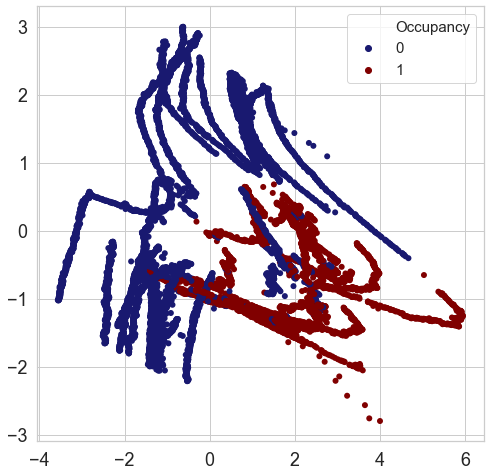

In [4]:
# da fare in 3D!
sns.set(style='whitegrid')
plt.figure(figsize=(8,8))
#plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue = df_training[class_name],
                palette=['midnightblue', 'maroon'], sizes=(1, 8), linewidth=0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=15)
plt.show()

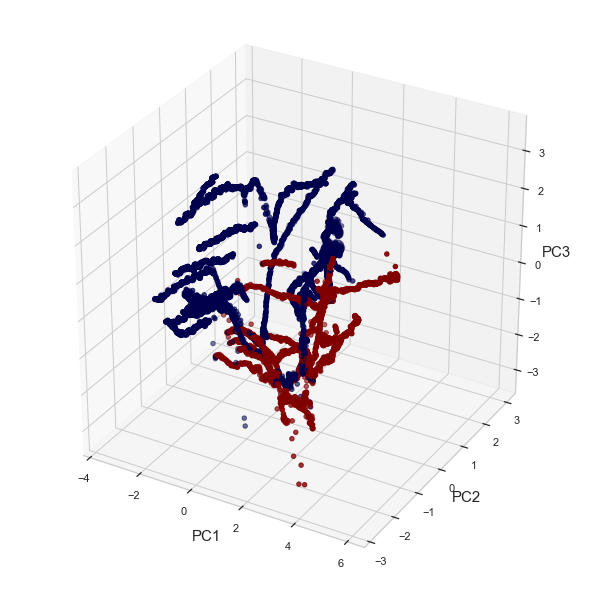

In [5]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_zlabel('PC3', fontsize=15)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    #plt.zticks(fontsize=15)
    matplotlib.rcParams.update({'font.size': 22})
    scalarMap.set_array(cs)
    #fig.colorbar(scalarMap)
    plt.show()

#%matplotlib notebook
scatter3d(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], y_train, 'seismic')

In [8]:
#Knn con parametri migliori (grid search), usando dati PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

X_test_pca = pca.transform(X_test)

parameters = {'n_neighbors': np.arange(1, 50 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters, n_jobs = -1)
search.fit(X_train_pca, y_train)

clf = search.best_estimator_

clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)

print()
print('Accuracy %s' % accuracy_score(y_test, y_pred_pca))
print('F1-score %s' % f1_score(y_test, y_pred_pca, average=None))
print(classification_report(y_test, y_pred_pca))
report = classification_report(y_test, y_pred_pca, output_dict=True)


Accuracy 0.873378728923476
F1-score [0.91805687 0.72156863]
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      5071
           1       0.59      0.92      0.72      1097

    accuracy                           0.87      6168
   macro avg       0.79      0.89      0.82      6168
weighted avg       0.91      0.87      0.88      6168

